# Well log data

First, let's plot the data to see what it looks like:

In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("well.dat", "r") as f:
    data = f.readlines()
    data = [float(x.strip()) for x in data[7:]]

Text(0.5, 1.0, 'Well log data')

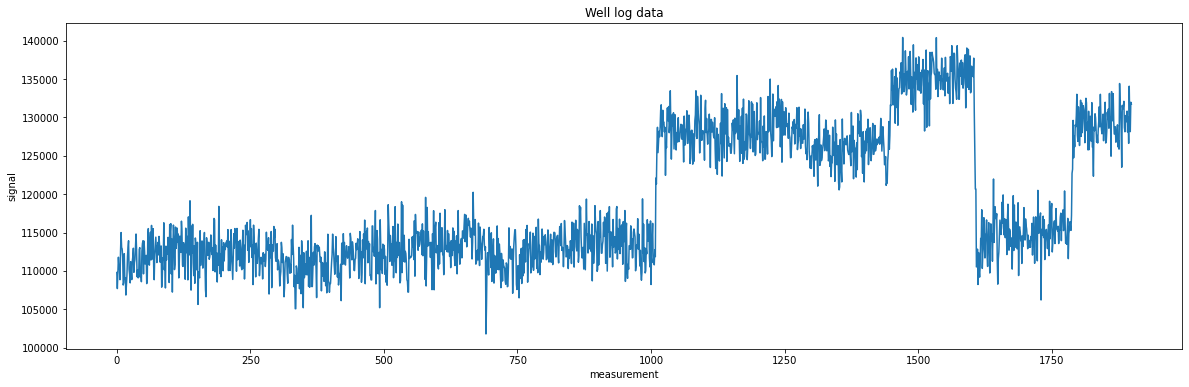

In [3]:
data = data[:1900] 

x = np.arange(len(data))

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, data)
ax.set_xlabel('measurement')
ax.set_ylabel('signal')
ax.set_title('Well log data')

We can distinguish at least 4 transitions. We assume that the signal produced by each type of rock is always the same, so that any noise will be produced by measurement errors. As such, we will model the signal using a gaussian distribution with fixed variance and leave the average as a free parameter.

In [4]:
def create_well_log_model(n_switchpoints):
    with pm.Model() as model:
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper) #average as a free parameter

        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= steps, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= steps, build_switch(id-1), rates[id+1])
        
        #switchpoints definitions
        switchpoints = [create_switchpoint(0, 0, len(data) - n_switchpoints)]
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i-1], len(data)-n_switchpoints+i))#quito el constraint del lower=switchpoints[i-1]+10
    
        #rates definitions
        rates = []
        for i in range(0, n_switchpoints+1):
            rates.append(create_rate(i, 105000, 140000))

        steps = np.arange(0, len(data))
        variance = pm.Uniform('variance', 1, 10000) 

        rate = build_switch(n_switchpoints-1)

        signal = pm.Normal('signal', rate, variance, observed=data) #gaussian distribution of data
    
    return model    

It seemed obvious that we should get 4 switchpoint, but for the sake of completeness let's compare the solution with 5 and 6 switchpoints:

In [5]:
traces = []

print(f"Running model with 4 switchpoints")
with create_well_log_model(4) as model:
      traces.append(pm.sample(10000, tune = 5000, return_inferencedata=True))

print(f"Running model with 5 switchpoints")
with create_well_log_model(5) as model:
      traces.append(pm.sample(10000, tune = 5000, return_inferencedata=True))
        
print(f"Running model with 6 switchpoints")
with create_well_log_model(6) as model:
      traces.append(pm.sample(10000, tune = 5000, return_inferencedata=True))

Running model with 4 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


Running model with 5 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 55 seconds.
There were 586 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6759694849326962, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1681 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5736153394721648, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.483118517261749, but should be close to 0.8. Try to increase the number of tuning steps.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The est

Running model with 6 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_5]
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_6, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 150 seconds.
There were 658 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7132683660099914, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4577 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23128621698432153, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9189917697356293, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [6]:
az.summary(traces[0], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,1008.009,0.098,1008.000,1008.000,0.001,0.001,5052.0,5101.0,1.0
switchpoint_1,1447.696,0.798,1447.000,1449.000,0.010,0.007,6473.0,6420.0,1.0
switchpoint_2,1605.832,0.374,1605.000,1606.000,0.005,0.003,5729.0,5729.0,1.0
switchpoint_3,1787.189,0.419,1787.000,1788.000,0.005,0.004,5905.0,6124.0,1.0
rate_0,112442.464,81.256,112286.412,112601.722,0.301,0.213,72774.0,33064.0,1.0
rate_1,127382.930,123.284,127133.258,127616.047,0.462,0.327,71206.0,32143.0,1.0
rate_2,135002.932,206.805,134594.540,135402.226,0.837,0.592,60948.0,31338.0,1.0
rate_3,114829.673,192.591,114454.538,115206.185,0.787,0.557,59794.0,31065.0,1.0
rate_4,129064.339,245.056,128587.953,129540.451,0.969,0.685,63922.0,32767.0,1.0
variance,2560.657,42.069,2476.946,2640.706,0.150,0.106,78846.0,31675.0,1.0


In [7]:
az.summary(traces[1], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,1008.008,0.092,1008.000,1008.000,0.001,0.001,4416.0,4421.0,1.00
switchpoint_1,1447.702,0.804,1447.000,1449.000,0.010,0.007,6837.0,6769.0,1.00
switchpoint_2,1605.850,0.358,1605.000,1606.000,0.005,0.003,5753.0,5753.0,1.00
switchpoint_3,1774.047,22.620,1719.000,1788.000,9.164,6.821,8.0,22.0,1.54
switchpoint_4,1790.662,6.225,1787.000,1795.000,0.713,0.506,14.0,16.0,1.19
rate_0,112440.764,81.889,112273.163,112594.241,1.507,1.066,2967.0,3106.0,1.00
rate_1,127379.674,123.319,127142.679,127620.973,2.429,1.718,2590.0,4231.0,1.00
rate_2,135003.837,205.336,134575.898,135400.512,3.818,2.701,2901.0,3124.0,1.00
rate_3,114754.608,228.278,114300.475,115194.064,39.722,28.339,35.0,293.0,1.07
rate_4,121710.015,4591.558,114870.519,127911.742,1419.834,1033.387,13.0,189.0,1.21


In [8]:
az.summary(traces[2], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,1008.008,0.096,1008.000,1008.000,0.002,0.001,3931.0,4053.0,1.00
switchpoint_1,1447.697,0.792,1447.000,1449.000,0.009,0.007,7043.0,6663.0,1.00
switchpoint_2,1605.635,0.543,1605.000,1606.000,0.173,0.126,10.0,9.0,1.33
switchpoint_3,1703.666,74.701,1608.000,1787.000,32.500,24.385,6.0,6.0,1.71
switchpoint_4,1787.867,2.069,1786.000,1793.000,0.408,0.292,21.0,430.0,1.15
switchpoint_5,1809.052,34.049,1787.000,1890.000,8.833,6.373,20.0,69.0,1.15
rate_0,112442.911,81.560,112277.557,112587.025,4.198,2.971,386.0,1213.0,1.02
rate_1,127377.540,125.455,127115.670,127614.350,7.491,5.302,286.0,319.0,1.03
rate_2,134992.134,206.033,134564.914,135360.587,17.800,12.616,135.0,1095.0,1.03
rate_3,116497.041,3817.764,112422.525,124483.754,1439.952,1063.715,11.0,36.0,1.53


array([[<AxesSubplot:title={'center':'switchpoint_0'}>,
        <AxesSubplot:title={'center':'switchpoint_0'}>],
       [<AxesSubplot:title={'center':'switchpoint_1'}>,
        <AxesSubplot:title={'center':'switchpoint_1'}>],
       [<AxesSubplot:title={'center':'switchpoint_2'}>,
        <AxesSubplot:title={'center':'switchpoint_2'}>],
       [<AxesSubplot:title={'center':'switchpoint_3'}>,
        <AxesSubplot:title={'center':'switchpoint_3'}>],
       [<AxesSubplot:title={'center':'rate_0'}>,
        <AxesSubplot:title={'center':'rate_0'}>],
       [<AxesSubplot:title={'center':'rate_1'}>,
        <AxesSubplot:title={'center':'rate_1'}>],
       [<AxesSubplot:title={'center':'rate_2'}>,
        <AxesSubplot:title={'center':'rate_2'}>],
       [<AxesSubplot:title={'center':'rate_3'}>,
        <AxesSubplot:title={'center':'rate_3'}>],
       [<AxesSubplot:title={'center':'rate_4'}>,
        <AxesSubplot:title={'center':'rate_4'}>],
       [<AxesSubplot:title={'center':'variance'}>,
  

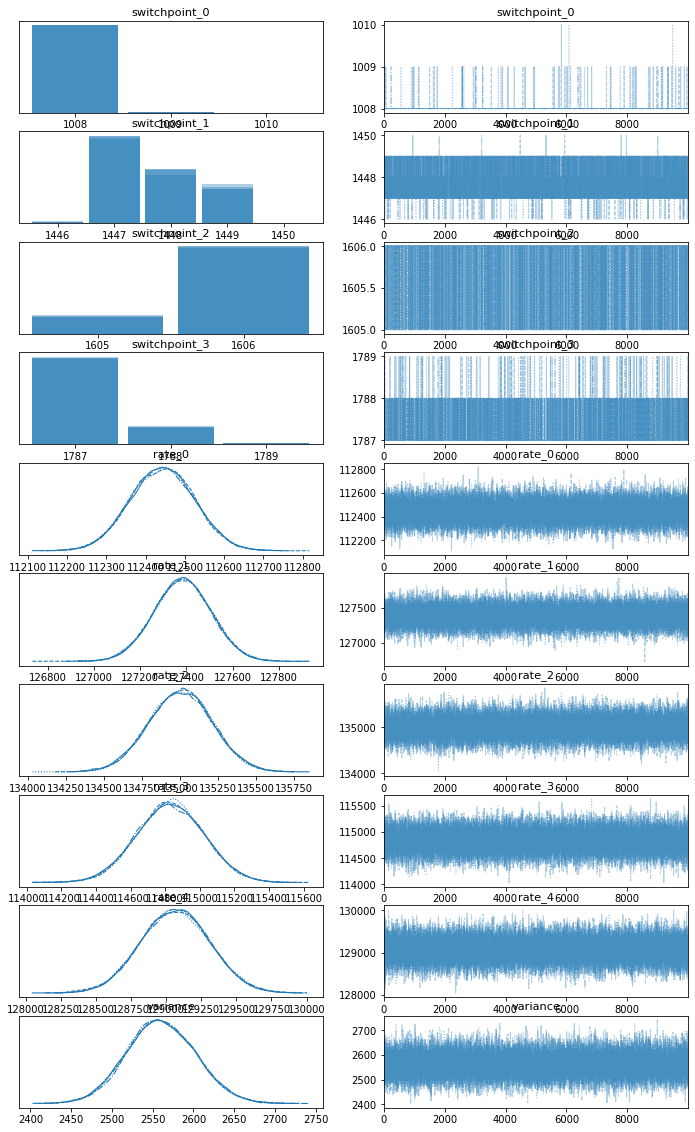

In [9]:
az.plot_trace(traces[0])

In [10]:
model_comp = az.compare({"4": traces[0], "5": traces[1], "6": traces[2]})
model_comp

/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
6,0,-17610.101854,23.387167,0.000000,0.574393,32.673133,0.000000,True,log
5,1,-17610.782243,13.532179,0.680389,0.000000,32.421733,1.629369,True,log
4,2,-17611.060566,8.009302,0.958712,0.425607,32.444515,3.438074,True,log


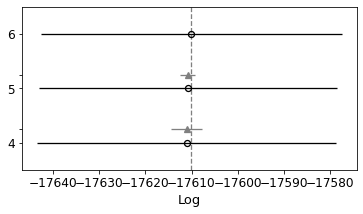

In [11]:
az.plot_compare(model_comp, insample_dev=False);

According to the loo the best model is the one with five switchpoints. Yet, when we look at the plot we can see that all models are compatible. Thus, we can choose whichever we prefer, or the one which is more reasonable given extra information. We will just plot the evolution to see if it makes sense:

In [12]:
prediction = [] 

print(f"Running model with 4 switchpoints")
with create_well_log_model(4) as model:
    prediction.append(pm.sample_posterior_predictive(traces[0], 10000))

print(f"Running model with 5 switchpoints")
with create_well_log_model(5) as model:
    prediction.append(pm.sample_posterior_predictive(traces[1], 10000))

print(f"Running model with 6 switchpoints")
with create_well_log_model(6) as model:
    prediction.append(pm.sample_posterior_predictive(traces[2], 10000))

Running model with 4 switchpoints


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Running model with 5 switchpoints


Running model with 6 switchpoints


In [14]:
def layout (n_switchpoints, i):
    trace=traces[i]
    
    x = np.arange(len(data))
    plot_steps = list(range(0, len(data), 500))

    posterior_quantile = np.percentile(prediction[i]["signal"], [2.5, 25, 50, 75, 97.5], axis=0)

    plt.plot(
        x, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    plt.fill_between(
        x, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    plt.plot(
          x, data,
          '--', color='k', markersize=3,
          label='Observed', alpha=.8)

    for i in range(0, n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" %(i)]), min(data), max(data), color='C1')

    plt.xticks(plot_steps)
    plt.ylabel('signal', fontsize='large')
    plt.xlabel('measurement', fontsize='large')

    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    return plt.tight_layout();

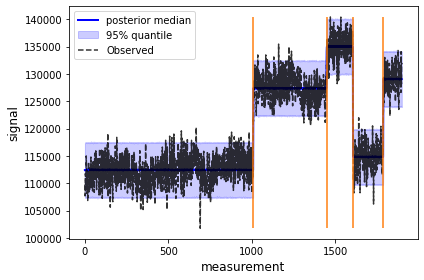

In [15]:
layout(4,0)

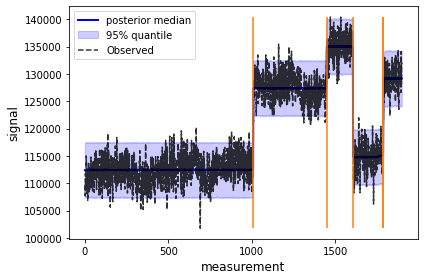

In [16]:
layout(5,1)

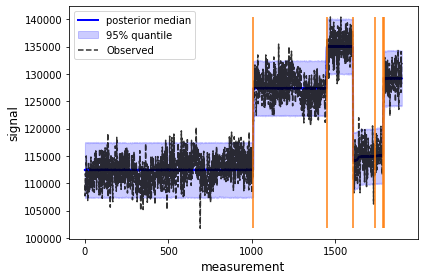

In [17]:
layout(6,2)

And we see that the five and six switchpoints model does not really add too much information since the rock would be extremely similar to the other ones in the sixth switchpoint. We can also see that if we allow a fifth switchpoint, this one is present in a similar step as the forth one.
